In [11]:
# lstm.py
import os
import json
import numpy as np
from typing import Any, List, Tuple, Dict, Union
from keras import layers, models, losses, optimizers
from keras.callbacks import History
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


class LSTMModel:
    def __init__(
        self,
        vocab_size: int,
        sequence_length: int = 100,
        embedding_dim: int = 128,
        lstm_layers: int = 1,
        lstm_units: Union[int, List[int]] = 64,
        bidirectional: bool = False,
        dense_units: List[int] = [128],
        dense_activations: List[str] = ["relu"],
    ):
        if isinstance(lstm_units, int):
            lstm_units = [lstm_units] * lstm_layers

        self.model = self._build_model(
            vocab_size,
            sequence_length,
            embedding_dim,
            lstm_layers,
            lstm_units,
            bidirectional,
            dense_units,
            dense_activations
        )

    def _build_model(
        self, vocab_size, seq_len, embed_dim, lstm_layers, lstm_units,
        bidirectional, dense_units, dense_activations
    ):
        model = models.Sequential(name="lstm_nusax")
        model.add(layers.Input(shape=(seq_len,), name="input"))
        model.add(layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, name="embedding"))

        for i in range(len(lstm_units)):
            return_seq = i < len(lstm_units) - 1
            lstm_layer = layers.LSTM(lstm_units[i], return_sequences=return_seq, name=f"lstm_{i+1}")
            if bidirectional:
                lstm_layer = layers.Bidirectional(lstm_layer, name=f"bilstm_{i+1}")
            model.add(lstm_layer)

        model.add(layers.Dropout(0.5, name="dropout"))

        for idx, (units, act) in enumerate(zip(dense_units, dense_activations)):
            model.add(layers.Dense(units, activation=act, name=f"dense_{idx+1}"))

        model.add(layers.Dense(3, activation="softmax", name="output"))  # 3 kelas
        return model

    def compile(self):
        self.model.compile(
            loss=losses.SparseCategoricalCrossentropy(),
            optimizer=optimizers.Adam(),
            metrics=["accuracy"],
        )

    def train(
        self, x_train, y_train, x_val, y_val,
        epochs: int = 5,
        batch_size: int = 32
    ) -> History:
        return self.model.fit(
            x_train,
            y_train,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

    def evaluate(self, x_test, y_test) -> float:
        y_pred_prob = self.model.predict(x_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        f1 = f1_score(y_test, y_pred, average="macro")
        print("Test Macro F1 Score:", f1)
        return f1

    def save(self, name="lstm_model.keras") -> str:
        path = os.path.join("saved_models", name)
        os.makedirs("saved_models", exist_ok=True)
        self.model.save(path)
        return path

    def save_history(self, history, name="lstm_history.json") -> str:
        path = os.path.join("saved_models", name)
        with open(path, "w") as f:
            json.dump(history, f)
        return path


# def run_training(path_to_data: str):
#     texts, labels = load_nusax_sentiment(path_to_data)

#     # Vectorization
#     max_tokens = 10000
#     max_len = 100
#     vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_len)
#     vectorizer.adapt(texts)
#     X = vectorizer(texts)
#     y = np.array(labels)

#     X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
#     X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#     # Build and train model
#     model = LSTMModel(vocab_size=max_tokens)
#     model.compile()
#     history = model.train(X_train, y_train, X_val, y_val, epochs=5)
#     f1 = model.evaluate(X_test, y_test)
#     model.save()
#     model.save_history(history.history)

#     return f1, history.history

# if __name__ == "__main__":
#     # Ganti dengan path file TSV dari NusaX-Sentiment
#     run_training("indonesia.tsv")

In [41]:
from __future__ import annotations

import os
from typing import Any, List, Protocol

import numpy as np
import numpy.typing as npt
from keras import models
from sklearn.metrics import f1_score


class ForwardLayer(Protocol):
    def forward(self, x: npt.NDArray[Any]) -> npt.NDArray[Any]: ...


_EPSILON = 1e-7


# -------------------- Embedding -------------------- #
class EmbeddingLayer:
    def __init__(self, weight: npt.NDArray[np.float32]) -> None:
        self.weight = weight.astype(np.float32)

    def forward(self, x: npt.NDArray[np.int32]) -> npt.NDArray[np.float32]:
        return self.weight[x]


# -------------------- LSTM (Unidirectional) -------------------- #
class LSTMLayer:
    def __init__(
        self,
        W: npt.NDArray[np.float32],
        U: npt.NDArray[np.float32],
        b: npt.NDArray[np.float32],
        return_sequences: bool = False, # Add this parameter
    ) -> None:
        self.W = W.astype(np.float32)  # (input_dim, 4*units)
        self.U = U.astype(np.float32)  # (units, 4*units)
        self.b = b.astype(np.float32)  # (4*units,)
        self.units = U.shape[0]
        self.return_sequences = return_sequences # Store the parameter

    def sigmoid(self, x: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return 1 / (1 + np.exp(-x))

    def tanh(self, x: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return np.tanh(x)

    def forward(self, x: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        # Expecting x shape (batch, time_steps, input_dim) if return_sequences=True from previous LSTM
        # Expecting x shape (batch, time_steps, input_dim) if input is from Embedding layer
        # Expecting x shape (batch, input_dim) if previous layer is Dense (which shouldn't happen with correct layer order)
        # Let's assume input is always 3D for LSTM layers in this setup based on Keras model structure
        if x.ndim != 3:
             raise ValueError(f"LSTMLayer expects 3D input (batch, time_steps, input_dim), but got {x.ndim}D input with shape {x.shape}")

        batch_size, time_steps, input_dim = x.shape
        h = np.zeros((batch_size, self.units), dtype=np.float32)
        c = np.zeros((batch_size, self.units), dtype=np.float32)

        # Store outputs for return_sequences=True
        if self.return_sequences:
            output_sequence = np.zeros((batch_size, time_steps, self.units), dtype=np.float32)

        for t in range(time_steps):
            xt = x[:, t, :]  # (batch, input_dim)
            # Ensure xt is 2D for matrix multiplication
            if xt.ndim == 1:
                xt = np.expand_dims(xt, axis=1) # Should not be needed if x is 3D

            # Reshape h and c if necessary (should be 2D)
            if h.ndim == 1:
                 h = np.expand_dims(h, axis=1)
            if c.ndim == 1:
                 c = np.expand_dims(c, axis=1)


            z = xt @ self.W + h @ self.U + self.b  # (batch, 4*units)


            i = self.sigmoid(z[:, :self.units])
            f = self.sigmoid(z[:, self.units:2*self.units])
            c_hat = self.tanh(z[:, 2*self.units:3*self.units])
            o = self.sigmoid(z[:, 3*self.units:])

            c = f * c + i * c_hat
            h = o * self.tanh(c)

            if self.return_sequences:
                output_sequence[:, t, :] = h # Store current hidden state

        if self.return_sequences:
            return output_sequence # Return 3D sequence
        else:
            return h


# -------------------- Dense -------------------- #
class DenseLayer:
    def __init__(
        self,
        weight: npt.NDArray[np.float32],
        bias: npt.NDArray[np.float32],
        activation: str = "linear",
    ) -> None:
        self.W = weight.astype(np.float32)
        self.b = bias.astype(np.float32)
        self.activation = activation.lower()

    def forward(self, x: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        z = x @ self.W + self.b
        if self.activation == "relu":
            return np.maximum(0, z)
        if self.activation == "tanh":
            return np.tanh(z)
        if self.activation == "sigmoid":
            return 1 / (1 + np.exp(-z))
        if self.activation == "softmax":
            exp = np.exp(z - np.max(z, axis=1, keepdims=True))
            return exp / np.sum(exp, axis=1, keepdims=True)
        return z  # linear


class BidirectionalLSTMLayer:
    def __init__(
        self,
        forward_weights: Tuple[npt.NDArray[np.float32], npt.NDArray[np.float32], npt.NDArray[np.float32]],
        backward_weights: Tuple[npt.NDArray[np.float32], npt.NDArray[np.float32], npt.NDArray[np.float32]],
        return_sequences: bool = False,
    ) -> None:
        self.forward_lstm = LSTMLayer(*forward_weights, return_sequences)
        self.backward_lstm = LSTMLayer(*backward_weights, return_sequences)
        self.return_sequences = return_sequences

    def forward(self, x: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        # Forward pass
        out_forward = self.forward_lstm.forward(x)
        # Reverse input along time axis (axis=1)
        out_backward = self.backward_lstm.forward(x[:, ::-1, :])
        if self.return_sequences:
            out_backward = out_backward[:, ::-1, :]  # Reverse time axis back
        # Concatenate hidden states along feature axis
        return np.concatenate([out_forward, out_backward], axis=-1)

# -------------------- Full Model -------------------- #
class ScratchLSTM:
    def __init__(self, keras_model_path: str) -> None:
        if not os.path.exists(keras_model_path):
            raise FileNotFoundError(keras_model_path)
        self.layers: List[ForwardLayer] = []
        self._build_from_keras(keras_model_path)

    def _build_from_keras(self, model_path: str) -> None:
        keras_model = models.load_model(model_path, compile=False)
        self.layers: List[ForwardLayer] = [] # Clear layers before building
        lstm_count = 0
        total_lstm_layers = sum(1 for layer in keras_model.layers if layer.__class__.__name__ == "LSTM")
        print(f"[DEBUG] Total LSTM layers in Keras model: {total_lstm_layers}")


        for layer in keras_model.layers:
            cls_name = layer.__class__.__name__
            print(f"[DEBUG] Processing Keras layer: {cls_name} - {layer.name}")
            if cls_name == "Embedding":
                w = layer.get_weights()[0]
                self.layers.append(EmbeddingLayer(w))
                print(f"[DEBUG] Added EmbeddingLayer")
            elif cls_name == "LSTM":
                W, U, b = layer.get_weights()
                lstm_count += 1
                # Infer return_sequences: True for all but the last LSTM layer
                return_sequences = lstm_count < total_lstm_layers
                self.layers.append(LSTMLayer(W, U, b, return_sequences=return_sequences))
                print(f"[DEBUG] Added LSTMLayer with units: {U.shape[0]}, return_sequences: {return_sequences}")
            elif cls_name == "Bidirectional":
                 # If Bidirectional is needed, you would need to implement it,
                 # which usually wraps an LSTM layer and its weights.
                 # For now, let's raise an error as it's not implemented.
                    print(f"[DEBUG] Adding BidirectionalLSTMLayer")
                    fw_weights = layer.forward_layer.get_weights()
                    bw_weights = layer.backward_layer.get_weights()
                    return_sequences = layer.return_sequences
                    self.layers.append(BidirectionalLSTMLayer(fw_weights, bw_weights, return_sequences))
            elif cls_name == "Dense":
                w, b = layer.get_weights()
                activation = layer.activation.__name__.lower()
                self.layers.append(DenseLayer(w, b, activation))
                print(f"[DEBUG] Added DenseLayer with units: {w.shape[1]}, activation: {activation}")
            elif cls_name == "Dropout":
                print(f"[DEBUG] Skipping Dropout layer")
                continue  # Dropout is skipped during inference
            else:
                print(f"[DEBUG] Warning: Unhandled Keras layer type: {cls_name}")

    def forward(self, x: npt.NDArray[Any]) -> npt.NDArray[np.float32]:
        out: npt.NDArray[Any] = x.astype(np.int32)
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def predict(self, x: npt.NDArray[Any]) -> npt.NDArray[np.int32]:
        return np.argmax(self.forward(x), axis=1)


In [4]:
import matplotlib.pyplot as plt
from typing import Dict, List


def plot_loss(
    history: Dict[str, List[float]], title: str = "Training and Validation Loss"
) -> None:
    """
    Plot training loss and validation loss over epochs.

    Parameters:
    -----------
    history : Dict[str, List[float]]
        Dictionary containing 'loss' and 'val_loss' lists from Keras History object.
    title : str, optional
        Title of the plot (default is "Training and Validation Loss").
    """
    loss = history.get("loss", [])
    val_loss = history.get("val_loss", [])

    if not loss or not val_loss:
        print("Warning: History does not contain 'loss' or 'val_loss' keys.")
        return

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, "bo-", label="Training loss")
    plt.plot(epochs, val_loss, "ro-", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_multi_loss(
    histories: Dict[str, Dict[str, List[float]]],
    title: str = "Training and Validation Loss Comparison",
) -> None:
    """
    Plot multiple training and validation losses in two subplots.

    Parameters:
    -----------
    histories : Dict[str, Dict[str, List[float]]]
        Dictionary where keys are experiment names and values are history dicts
        containing 'loss' and 'val_loss' lists.
    title : str, optional
        Title of the whole figure (default is "Training and Validation Loss Comparison").
    """
    plt.figure(figsize=(14, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        loss = history.get("loss", [])
        if loss:
            epochs = range(1, len(loss) + 1)
            plt.plot(epochs, loss, marker="o", label=name)
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Plot validation loss
    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        val_loss = history.get("val_loss", [])
        if val_loss:
            epochs = range(1, len(val_loss) + 1)
            plt.plot(epochs, val_loss, marker="o", label=name)
    plt.title("Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))
    plt.show()


[MAIN] LSTMSuite demo started.
[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_model.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[START] Training LSTM model...
Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.3651 - loss: 1.0912 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3296 - loss: 1.0825 - val_accuracy: 0.3800 - val_loss: 1.0792
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3923 - loss: 1.0745 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3914 - loss: 1.0814 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4048 - loss: 1.0812 - val_accuracy: 0.3800 - val_loss: 1.0781
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test Macro F1 Score: 0.18269812462189958
[DONE] Training comple

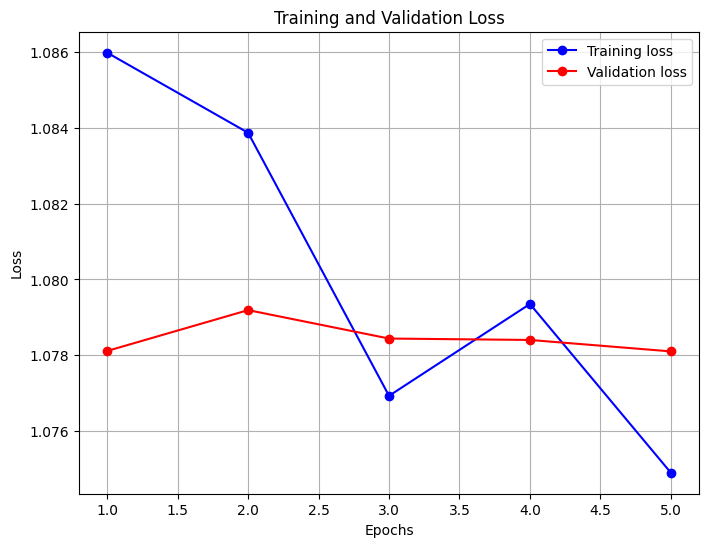

[DONE] Plot displayed.
[MAIN] LSTMSuite demo finished.


In [14]:
from __future__ import annotations

import json
import os
from pathlib import Path
from typing import Dict, List, Tuple, Union

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from keras.layers import TextVectorization


# ------------------------------------------------------------
# Data loader (train / val / test split)
# ------------------------------------------------------------
def load_nusax_sentiment(
) -> Tuple[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]:
    print("[INFO] Loading train/val/test from individual CSVs...")

    df_train = pd.read_csv("https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/train.csv")
    df_val = pd.read_csv("https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/valid.csv")
    df_test = pd.read_csv("https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/test.csv")

    all_text = pd.concat([df_train['text'], df_val['text'], df_test['text']]).astype(str).values
    vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=100)
    vectorizer.adapt(all_text)

    le = LabelEncoder()
    le.fit(pd.concat([df_train['label'], df_val['label'], df_test['label']]))

    def prepare(df):
        X = vectorizer(df['text'].astype(str).values).numpy()
        y = le.transform(df['label'].values)
        return X, y

    return prepare(df_train), prepare(df_val), prepare(df_test)


# ------------------------------------------------------------
# Pipeline wrapper class
# ------------------------------------------------------------
class LSTMSuite:
    def __init__(self, save_dir: str = "saved_models", model_name: str = "lstm_model.keras") -> None:
        print(f"[INIT] Initializing LSTMSuite with model path '{save_dir}/{model_name}'")
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.model_path = self.save_dir / model_name
        self.history_path = self.save_dir / "lstm_history.json"

        self.data: Dict[str, Tuple[np.ndarray, np.ndarray]] = {}
        self.history: Dict[str, List[float]] | None = None
        self.vectorizer: TextVectorization | None = None
        self.label_encoder: LabelEncoder | None = None


    def load_data(self) -> None:
      print("[START] Loading dataset...")

      df_train = pd.read_csv("https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/train.csv")
      df_val = pd.read_csv("https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/valid.csv")
      df_test = pd.read_csv("https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/test.csv")

      all_text = pd.concat([df_train['text'], df_val['text'], df_test['text']]).astype(str).values
      vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=100)
      vectorizer.adapt(all_text)
      self.vectorizer = vectorizer

      le = LabelEncoder()
      le.fit(pd.concat([df_train['label'], df_val['label'], df_test['label']]))
      self.label_encoder = le

      def prepare(df):
          X = vectorizer(df['text'].astype(str).values).numpy()
          y = le.transform(df['label'].values)
          return X, y

      train = prepare(df_train)
      val = prepare(df_val)
      test = prepare(df_test)
      self.data = {
          "train": train,
          "val": val,
          "test": test,
      }

      print("[DONE] Dataset loaded:")
      for k, (x, y) in self.data.items():
          print(f"  - {k}: {x.shape}, {y.shape}")


    def train(
        self,
        epochs: int = 5,
        batch_size: int = 64,
        embedding_dim: int = 128,
        lstm_layers: int = 1,
        lstm_units: Union[int, List[int]] = 64,
        bidirectional: bool = False,
        dense_units: List[int] = [128],
        dense_activations: List[str] = ["relu"],
    ) -> None:
        if not self.data:
            raise RuntimeError("Call load_data() first")

        print(f"[START] Training LSTM model...")
        x_tr, y_tr = self.data["train"]
        x_val, y_val = self.data["val"]
        x_test, y_test = self.data["test"]

        model = LSTMModel(
            vocab_size=10000,
            embedding_dim=embedding_dim,
            lstm_layers=lstm_layers,
            lstm_units=lstm_units,
            bidirectional=bidirectional,
            dense_units=dense_units,
            dense_activations=dense_activations,
        )
        model.compile()
        history = model.train(x_tr, y_tr, x_val, y_val, epochs=epochs, batch_size=batch_size)
        f1 = model.evaluate(x_test, y_test)
        model.save(self.model_path.name)
        model.save_history(history.history, name=self.history_path.name)
        self.history = history.history
        print(f"[DONE] Training complete - macro F1 on test (Keras): {f1:.4f}")

    def evaluate_keras(self) -> float:
        from keras.models import load_model

        if not self.model_path.exists():
            raise FileNotFoundError(self.model_path)
        x_test, y_test = self.data.get("test", (None, None))
        if x_test is None:
            raise RuntimeError("Test data not loaded")

        print("[START] Evaluating Keras model on test set...")
        model = load_model(self.model_path, compile=False)
        y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)
        score = f1_score(y_test, y_pred, average="macro")
        print(f"[DONE] Macro F1-score (Keras): {score:.4f}")
        return score

    def evaluate_scratch(self) -> float:
        if self.vectorizer is None or self.label_encoder is None:
            raise RuntimeError("Vectorizer or LabelEncoder not initialized. Call load_data() first.")

        print("[START] Loading and preparing test data from NusaX...")
        df_test = pd.read_csv("https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/test.csv")
        texts = df_test["text"].astype(str).values
        labels = self.label_encoder.transform(df_test["label"].values)

        x_test = self.vectorizer(texts).numpy()
        y_test = np.array(labels)

        print("[START] Evaluating scratch LSTM on test set...")
        scratch_model = ScratchLSTM(str(self.model_path))
        y_pred = scratch_model.predict(x_test)
        score = f1_score(y_test, y_pred, average="macro")
        print(f"[DONE] Macro F1-score (scratch): {score:.4f}")
        return score


    def load_history(self) -> Dict[str, List[float]]:
        if self.history is not None:
            print("[INFO] Using cached training history.")
            return self.history
        if not self.history_path.exists():
            raise FileNotFoundError(self.history_path)
        print(f"[INFO] Loading training history from {self.history_path}...")
        with open(self.history_path, "r") as f:
            self.history = json.load(f)
        print("[INFO] Training history loaded.")
        return self.history

    def plot_history(self) -> None:
        print("[START] Plotting training loss and accuracy history...")
        history = self.load_history()
        plot_loss(history)
        print("[DONE] Plot displayed.")


# ------------------------------------------------------------
# Quick demo
# ------------------------------------------------------------
if __name__ == "__main__":
    print("[MAIN] LSTMSuite demo started.")
    suite = LSTMSuite()
    suite.load_data()  # path ke file NusaX
    suite.train(epochs=5)
    suite.evaluate_keras()
    suite.evaluate_scratch()
    suite.plot_history()
    print("[MAIN] LSTMSuite demo finished.")


## Hyperparameter: Number of LSTM Layers

### 1. Number of LSTM Layers = 1

[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_lstmLayer_1.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[START] Training LSTM model...
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3247 - loss: 1.0966 - val_accuracy: 0.3800 - val_loss: 1.0810
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3915 - loss: 1.0801 - val_accuracy: 0.3800 - val_loss: 1.0814
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3769 - loss: 1.0800 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3890 - loss: 1.0705 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3499 - loss: 1.0874 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3906 - loss: 1.0714 - val_accuracy: 0.3800 - val_loss: 1.078

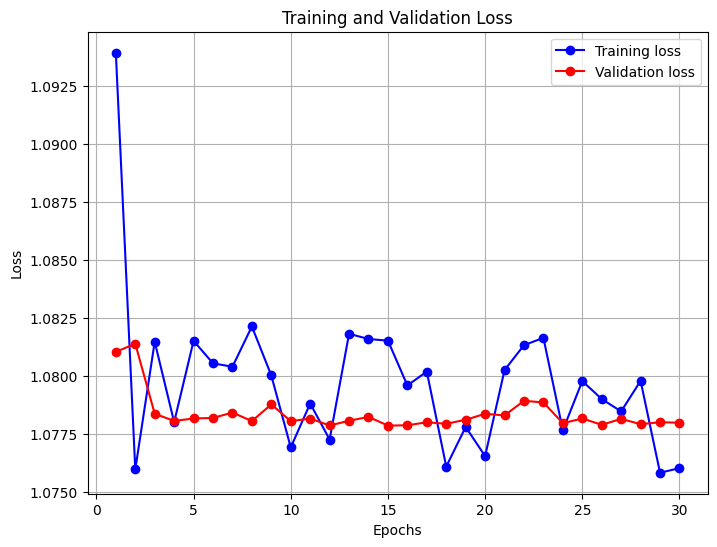

[DONE] Plot displayed.
[RESULT] LSTM Layers = 1 | Keras F1 = 0.184448 | Scratch F1 = 0.184448



In [28]:
lstm_lstmLayer_1 = LSTMSuite(save_dir="saved_models", model_name="lstm_lstmLayer_1.keras")
lstm_lstmLayer_1.history_path = Path("saved_models/lstm_lstmLayer_1_history.json")
lstm_lstmLayer_1.load_data()

if lstm_lstmLayer_1.model_path.exists() and lstm_lstmLayer_1.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_lstmLayer_1.load_history()
else:
    lstm_lstmLayer_1.train(epochs=30, batch_size=32, lstm_layers=1, lstm_units=64)

keras_lstm_lstmLayer_1 = lstm_lstmLayer_1.evaluate_keras()
scratch_lstm_lstmLayer_1 = lstm_lstmLayer_1.evaluate_scratch()
lstm_lstmLayer_1.plot_history()
print(f"[RESULT] LSTM Layers = 1 | Keras F1 = {keras_lstm_lstmLayer_1:.6f} | Scratch F1 = {scratch_lstm_lstmLayer_1:.6f}\n")


[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_lstmLayer_3.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[START] Training LSTM model...
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.4034 - loss: 1.0916 - val_accuracy: 0.3800 - val_loss: 1.0805
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3742 - loss: 1.0815 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3875 - loss: 1.0875 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4092 - loss: 1.0766 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3344 - loss: 1.0805 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4051 - loss: 1.0722 - val_accuracy: 0.3800 - val_loss: 1.078

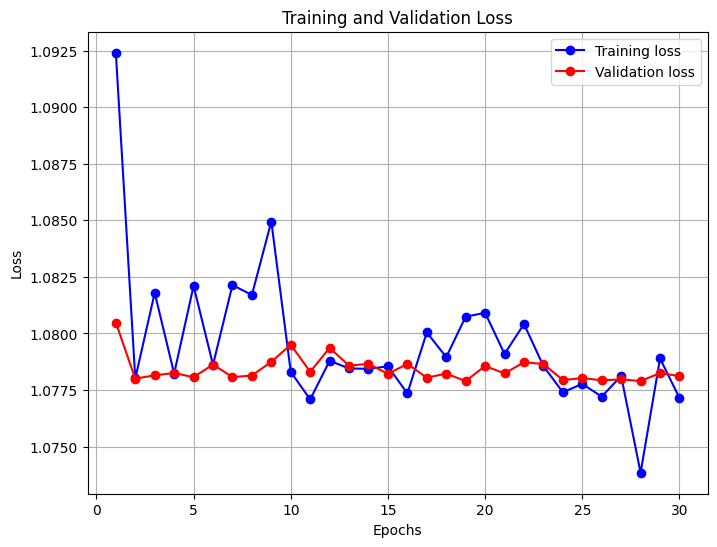

[DONE] Plot displayed.
[RESULT] LSTM Layers = 3 | Keras F1 = 0.184448 | Scratch F1 = 0.184448



In [29]:
lstm_lstmLayer_3 = LSTMSuite(save_dir="saved_models", model_name="lstm_lstmLayer_3.keras")
lstm_lstmLayer_3.history_path = Path("saved_models/lstm_lstmLayer_3_history.json")
lstm_lstmLayer_3.load_data()

if lstm_lstmLayer_3.model_path.exists() and lstm_lstmLayer_3.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_lstmLayer_3.load_history()
else:
    lstm_lstmLayer_3.train(epochs=30, batch_size=32, lstm_layers=3, lstm_units=64)

keras_lstm_lstmLayer_3 = lstm_lstmLayer_3.evaluate_keras()
scratch_lstm_lstmLayer_3 = lstm_lstmLayer_3.evaluate_scratch()
lstm_lstmLayer_3.plot_history()
print(f"[RESULT] LSTM Layers = 3 | Keras F1 = {keras_lstm_lstmLayer_3:.6f} | Scratch F1 = {scratch_lstm_lstmLayer_3:.6f}\n")


[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_lstmLayer_5.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[START] Training LSTM model...
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.3538 - loss: 1.0924 - val_accuracy: 0.3800 - val_loss: 1.0852
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3812 - loss: 1.0858 - val_accuracy: 0.3800 - val_loss: 1.0815
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3914 - loss: 1.0848 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4074 - loss: 1.0764 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4115 - loss: 1.0668 - val_accuracy: 0.3800 - val_loss: 1.0828
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3838 - loss: 1.0812 - val_accuracy: 0.3800 - val_loss: 1.07

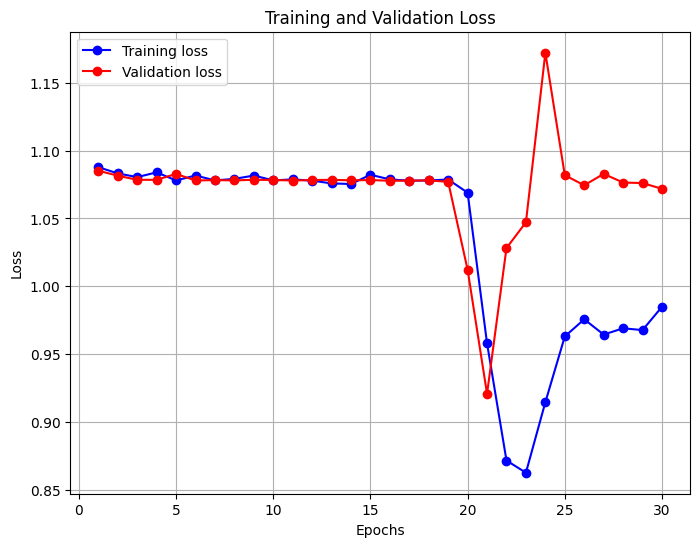

[DONE] Plot displayed.
[RESULT] LSTM Layers = 5 | Keras F1 = 0.292821 | Scratch F1 = 0.292821



In [30]:
lstm_lstmLayer_5 = LSTMSuite(save_dir="saved_models", model_name="lstm_lstmLayer_5.keras")
lstm_lstmLayer_5.history_path = Path("saved_models/lstm_lstmLayer_5_history.json")
lstm_lstmLayer_5.load_data()

if lstm_lstmLayer_5.model_path.exists() and lstm_lstmLayer_5.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_lstmLayer_5.load_history()
else:
    lstm_lstmLayer_5.train(epochs=30, batch_size=32, lstm_layers=5, lstm_units=64)

keras_lstm_lstmLayer_5 = lstm_lstmLayer_5.evaluate_keras()
scratch_lstm_lstmLayer_5 = lstm_lstmLayer_5.evaluate_scratch()
lstm_lstmLayer_5.plot_history()
print(f"[RESULT] LSTM Layers = 5 | Keras F1 = {keras_lstm_lstmLayer_5:.6f} | Scratch F1 = {scratch_lstm_lstmLayer_5:.6f}\n")


## 2. Hyperparameters: Number of Cells

[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_lstmCells_10.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[INFO] Model and history already exist. Skipping training and loading history...
[INFO] Loading training history from saved_models/lstm_lstmCells10_history.json...
[INFO] Training history loaded.
[START] Evaluating Keras model on test set...
[DONE] Macro F1-score (Keras): 0.1844
[START] Loading and preparing test data from NusaX...
[START] Evaluating scratch LSTM on test set...
[DEBUG] Total LSTM layers in Keras model: 5
[DEBUG] Processing Keras layer: Embedding - embedding
[DEBUG] Added EmbeddingLayer
[DEBUG] Processing Keras layer: LSTM - lstm_1
[DEBUG] Added LSTMLayer with units: 10, return_sequences: True
[DEBUG] Processing Keras layer: LSTM - lstm_2
[DEBUG] Added LSTMLayer with units: 10, return_sequences: True
[DEBUG] Processing Keras layer: LSTM - lstm_3
[DEBUG

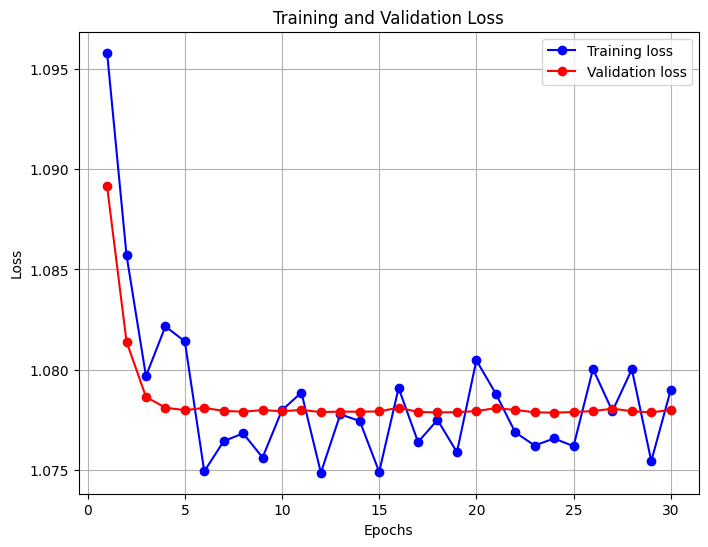

[DONE] Plot displayed.
[RESULT] LSTM Layers = 5 | Keras F1 = 0.184448 | Scratch F1 = 0.184448



In [34]:
lstm_lstmCells_10 = LSTMSuite(save_dir="saved_models", model_name="lstm_lstmCells_10.keras")
lstm_lstmCells_10.history_path = Path("saved_models/lstm_lstmCells10_history.json")
lstm_lstmCells_10.load_data()

if lstm_lstmCells_10.model_path.exists() and lstm_lstmCells_10.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_lstmCells_10.load_history()
else:
    lstm_lstmCells_10.train(epochs=30, batch_size=32, lstm_layers=5, lstm_units=10)

keras_lstm_lstmCells_10 = lstm_lstmCells_10.evaluate_keras()
scratch_lstm_lstmCells_10 = lstm_lstmCells_10.evaluate_scratch()
lstm_lstmCells_10.plot_history()
print(f"[RESULT] LSTM Units = 10 | Keras F1 = {keras_lstm_lstmCells_10:.6f} | Scratch F1 = {scratch_lstm_lstmCells_10:.6f}\n")


[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_lstmCells_64.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[START] Training LSTM model...
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.4019 - loss: 1.0936 - val_accuracy: 0.3800 - val_loss: 1.0792
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3656 - loss: 1.0768 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3849 - loss: 1.0770 - val_accuracy: 0.3800 - val_loss: 1.0816
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4155 - loss: 1.0786 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3760 - loss: 1.0817 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4018 - loss: 1.0717 - val_accuracy: 0.3800 - val_loss: 1.0

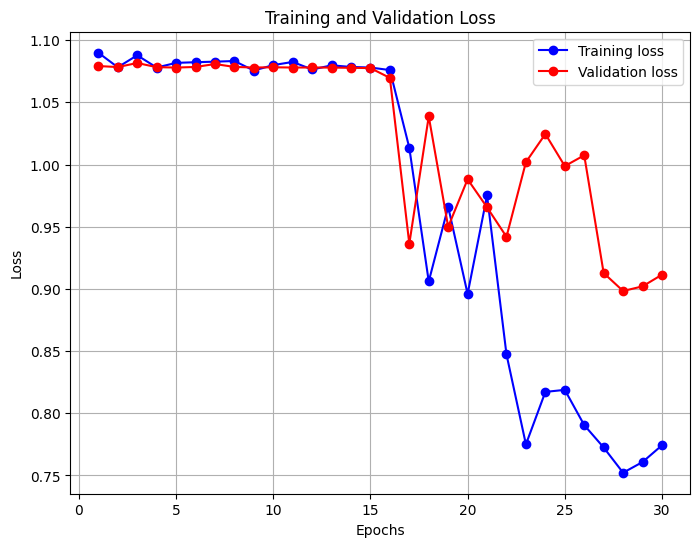

[DONE] Plot displayed.
[RESULT] LSTM Units = 64 | Keras F1 = 0.427491 | Scratch F1 = 0.427491



In [35]:
lstm_lstmCells_64 = LSTMSuite(save_dir="saved_models", model_name="lstm_lstmCells_64.keras")
lstm_lstmCells_64.history_path = Path("saved_models/lstm_lstmCells64_history.json")
lstm_lstmCells_64.load_data()

if lstm_lstmCells_64.model_path.exists() and lstm_lstmCells_64.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_lstmCells_64.load_history()
else:
    lstm_lstmCells_64.train(epochs=30, batch_size=32, lstm_layers=5, lstm_units=64)

keras_lstm_lstmCells_64 = lstm_lstmCells_64.evaluate_keras()
scratch_lstm_lstmCells_64 = lstm_lstmCells_64.evaluate_scratch()
lstm_lstmCells_64.plot_history()
print(f"[RESULT] LSTM Units = 64 | Keras F1 = {keras_lstm_lstmCells_64:.6f} | Scratch F1 = {scratch_lstm_lstmCells_64:.6f}\n")


[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_lstmCells_128.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[START] Training LSTM model...
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.3769 - loss: 1.0930 - val_accuracy: 0.3800 - val_loss: 1.0807
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3654 - loss: 1.0822 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4272 - loss: 1.0749 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3835 - loss: 1.0666 - val_accuracy: 0.3800 - val_loss: 1.0801
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3736 - loss: 1.0843 - val_accuracy: 0.3800 - val_loss: 1.0818
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3577 - loss: 1.0809 - val_accuracy: 0.3800 - val_loss: 1.

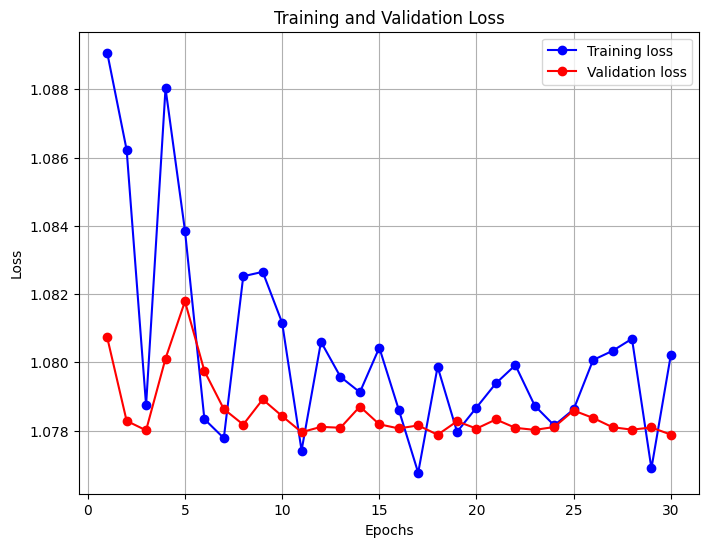

[DONE] Plot displayed.
[RESULT] LSTM Units = 128 | Keras F1 = 0.182698 | Scratch F1 = 0.182698



In [36]:
lstm_lstmCells_128 = LSTMSuite(save_dir="saved_models", model_name="lstm_lstmCells_128.keras")
lstm_lstmCells_128.history_path = Path("saved_models/lstm_lstmCells128_history.json")
lstm_lstmCells_128.load_data()

if lstm_lstmCells_128.model_path.exists() and lstm_lstmCells_128.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_lstmCells_128.load_history()
else:
    lstm_lstmCells_128.train(epochs=30, batch_size=32, lstm_layers=5, lstm_units=128)

keras_lstm_lstmCells_128 = lstm_lstmCells_128.evaluate_keras()
scratch_lstm_lstmCells_128 = lstm_lstmCells_128.evaluate_scratch()
lstm_lstmCells_128.plot_history()
print(f"[RESULT] LSTM Units = 128 | Keras F1 = {keras_lstm_lstmCells_128:.6f} | Scratch F1 = {scratch_lstm_lstmCells_128:.6f}\n")


## Hyperparameter: Unidirectional/Bidirectional

[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_unidirectional.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[START] Training LSTM model...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.3453 - loss: 1.0969 - val_accuracy: 0.3800 - val_loss: 1.0881
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3947 - loss: 1.0846 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3562 - loss: 1.0839 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3730 - loss: 1.0788 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3385 - loss: 1.0862 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3870 - loss: 1.0910 - val_accuracy: 0.3800 - 

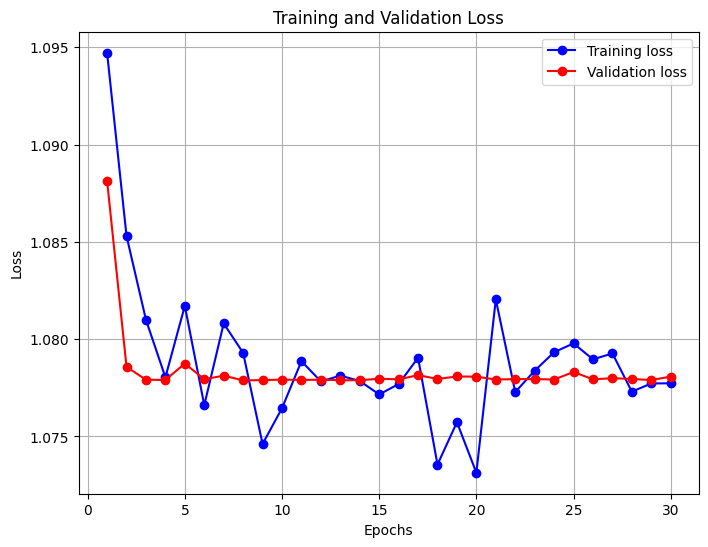

[DONE] Plot displayed.
[RESULT] LSTM Units = 128 | Keras F1 = 0.184448 | Scratch F1 = 0.184448



In [39]:
lstm_unidirectional = LSTMSuite(save_dir="saved_models", model_name="lstm_unidirectional.keras")
lstm_unidirectional.history_path = Path("saved_models/lstm_unidirectional_history.json")
lstm_unidirectional.load_data()

if lstm_unidirectional.model_path.exists() and lstm_unidirectional.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_unidirectional.load_history()
else:
    lstm_unidirectional.train(epochs=30, batch_size=32, lstm_layers=5, lstm_units=10, bidirectional=False)

keras_lstm_unidirectional = lstm_unidirectional.evaluate_keras()
scratch_lstm_unidirectional = lstm_unidirectional.evaluate_scratch()
lstm_unidirectional.plot_history()
print(f"[RESULT] LSTM Units = 128 | Keras F1 = {keras_lstm_unidirectional:.6f} | Scratch F1 = {scratch_lstm_unidirectional:.6f}\n")


[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_bidirectional.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[INFO] Model and history already exist. Skipping training and loading history...
[INFO] Loading training history from saved_models/lstm_bidirectional_history.json...
[INFO] Training history loaded.
[START] Evaluating Keras model on test set...
[DONE] Macro F1-score (Keras): 0.6332
[START] Loading and preparing test data from NusaX...
[START] Evaluating scratch LSTM on test set...
[DEBUG] Total LSTM layers in Keras model: 0
[DEBUG] Processing Keras layer: Embedding - embedding
[DEBUG] Added EmbeddingLayer
[DEBUG] Processing Keras layer: Bidirectional - bilstm_1
[DEBUG] Adding BidirectionalLSTMLayer
[DEBUG] Processing Keras layer: Bidirectional - bilstm_2
[DEBUG] Adding BidirectionalLSTMLayer
[DEBUG] Processing Keras layer: Bidirectional - bilstm_3
[DEBUG] Adding Bidir

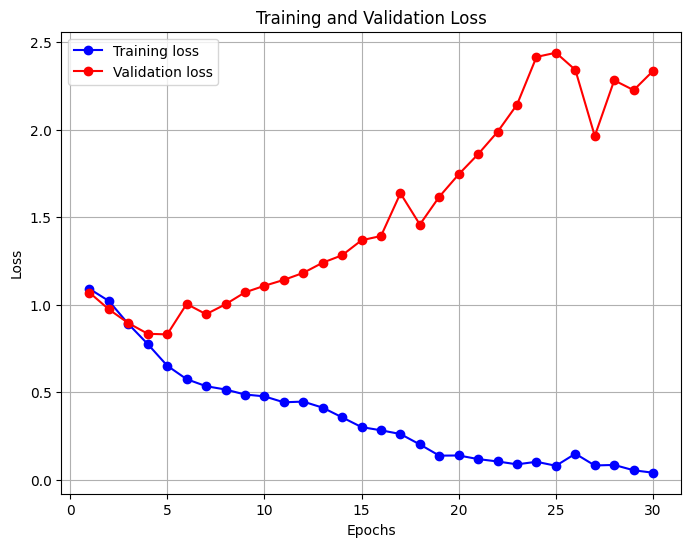

[DONE] Plot displayed.
[RESULT] LSTM Units = 128 | Keras F1 = 0.633176 | Scratch F1 = 0.633176



In [42]:
lstm_bidirectional = LSTMSuite(save_dir="saved_models", model_name="lstm_bidirectional.keras")
lstm_bidirectional.history_path = Path("saved_models/lstm_bidirectional_history.json")
lstm_bidirectional.load_data()

if lstm_bidirectional.model_path.exists() and lstm_bidirectional.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_bidirectional.load_history()
else:
    lstm_bidirectional.train(epochs=30, batch_size=32, lstm_layers=5, lstm_units=10, bidirectional=True)

keras_lstm_bidirectional = lstm_bidirectional.evaluate_keras()
scratch_lstm_bidirectinoal = lstm_bidirectional.evaluate_scratch()
lstm_bidirectional.plot_history()
print(f"[RESULT] LSTM Units = 128 | Keras F1 = {keras_lstm_bidirectional:.6f} | Scratch F1 = {scratch_lstm_bidirectinoal:.6f}\n")
